# Bias & Fairness in algorithms
## Ethical AI Toolkit
## On the responsible use of data in Machine Learning models

- Workshop @Datacraft 28/04/2021

In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

%matplotlib inline
%load_ext autoreload
%autoreload 2

## TODO
- Tour de table
- Tuto
- Streamlit
- Demo AIF360 http://aif360.mybluemix.net/data
- Definition des métriques de biais
- Simpson Paradox
- Causality & counfounders

## References
- AI Fairness 360
- Substra.ai article
- https://www.ibm.com/blogs/ibm-france/2019/10/14/aif-360-une-bibliotheque-open-source-pour-un-apprentissage-automatique-equitable/
- https://krvarshney.github.io/pubs/MahoneyVH2020.pdf

# Dataset

## Loading data

German risk scoring dataset from https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)<br>
Processed using https://www.kaggle.com/pahulpreet/german-credit-risk-analysis-beginner-s-guide

##### Credit risk
Credit Risk is the probable risk of loss resulting from a borrower's failure to repay a loan or meet contractual obligations. If a company offers credit to its client,then there is a risk that its clients may not pay their invoices.

##### Types of Credit Risk
- **Good Risk**: An investment that one believes is likely to be profitable. The term most often refers to a loan made to a creditworthy person or company. Good risks are considered exceptionally likely to be repaid.
- **Bad Risk**: A loan that is unlikely to be repaid because of bad credit history, insufficient income, or some other reason. A bad risk increases the risk to the lender and the likelihood of default on the part of the borrower.

##### Objective:
Based on the attributes, classify a person as good or bad credit risk.

##### Dataset Description:
The dataset contains 1000 entries with 20 independent variables (7 numerical, 13 categorical) and 1 target variable prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes.The attributes are:

In [19]:
data = pd.read_csv("../data/german-risk-scoring.csv")
target = 'Cost Matrix(Risk)'

data["sex"] = data["Personal status and sex"].map(lambda x : x.split(":")[0])
data = data.rename(columns = {"Age in years":"age"})

discrimination_rate = 0.5
discriminated_population = data.query("sex=='female' and age<=25").index.tolist()
print(len(discriminated_population))
np.random.shuffle(discriminated_population)
discriminated_population = discriminated_population[:int(discrimination_rate*len(discriminated_population))]
print(len(discriminated_population))
data.loc[discriminated_population,target] = "Bad Risk"

105
52


## Exploratory Data Analysis

In [20]:
import sys
sys.path.append("../")

from ekit.dataset import ClassificationDataset

dataset = ClassificationDataset(data,target)

In [21]:
dataset.plot("sex",norm = True)

In [22]:
dataset.notebook_plot(norm = True)

interactive(children=(Dropdown(description='col', options=('Status of existing checking account', 'Duration in…

# Bias evaluation

In [23]:
from ekit.study import ClassificationStudy
from ekit.utils import *

In [117]:
study = ClassificationStudy(
    dataset.data, 
    target = target, 
    favorable_classes = lambda x : x == "Good Risk", 
    protected_attribute_names=['sex',"age"],
    privileged_classes=[lambda x: x == "male",lambda x : x >= 25],
)

train,test = study.train_test_split(0.7)

In [118]:
# study = ClassificationStudy(
#     dataset.data, 
#     target = target, 
#     favorable_classes = lambda x : x == "Good Risk", 
#     protected_attribute_names=["sex"],
#     privileged_classes=[lambda x : x == "male"],
#     features_to_drop=["age","Personal status and sex"]
# )

# train,test = study.train_test_split(0.7)

In [34]:
study.compute_bias_metrics()

,disparate_impact,statistical_parity_difference
objective,0.00000,1.000000
sex,0.75383,-0.178027


In [35]:
study.fit(train,method = "lr")

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


{'confusion_matrix': array([[ 49,  45],
        [ 26, 180]], dtype=int64),
 'accuracy': 0.7633333333333333,
 'recall': 0.8737864077669902,
 'roc_auc': 0.6975315017558354}

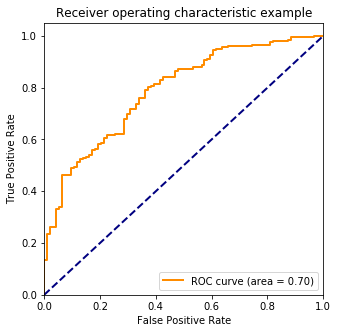

In [36]:
study.evaluate_performances(test)

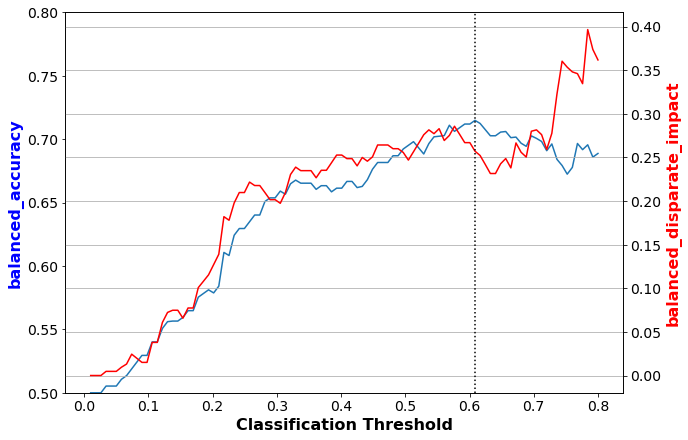

In [81]:
metrics = study.evaluate_bias(test)
study.plot_bias_metrics(metrics)

Here we plot the balanced disparate impact $1 - \min(\text{disparate impact}, 1/\text{disparate impact})$ since it's possible to overcorrect and end up with a value greater than 1, implying unfairness for the original privileged group. For shorthand, we simply call this 1-min(DI, 1/DI) from now on. We want the plotted metric to be less than 0.2.

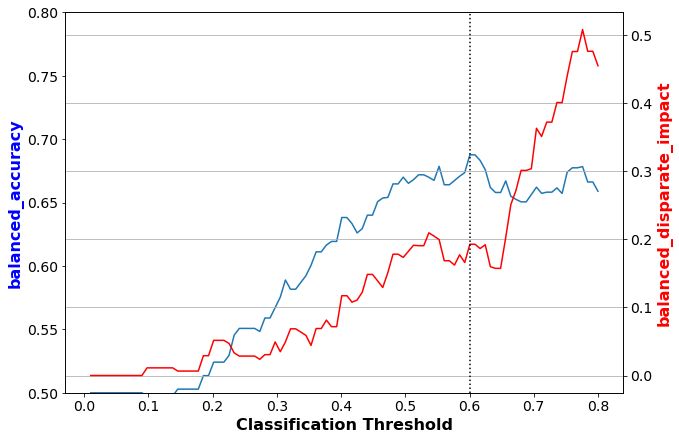

In [82]:
study.fit(train,method = "rf")
metrics = study.evaluate_bias(test)
study.plot_bias_metrics(metrics)

In [97]:
rw_train = study.pre_mitigate_reweighing(train)
dir_train = study.pre_mitigate_disparate_impact_remover(train)

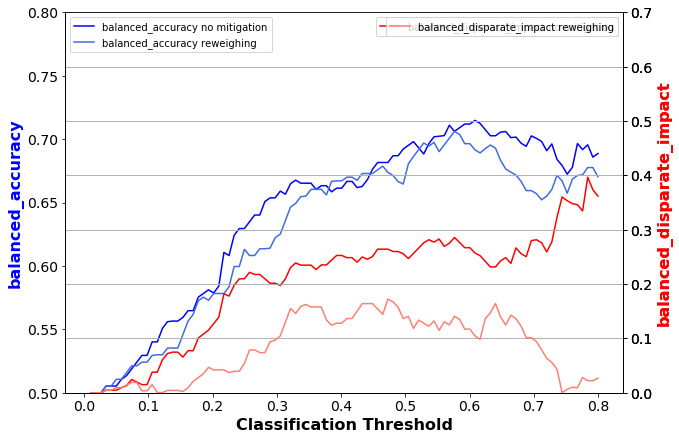

In [116]:
study.fit(train,method = "lr")
metrics = study.evaluate_bias(test)

study.fit(rw_train,method = "lr")
rw_metrics = study.evaluate_bias(test)

study.plot_bias_metrics([metrics,rw_metrics],labels = ["no mitigation","reweighing"])

# study.fit(rw_train,method = "lr")
# metrics = study.evaluate_bias(test)
# study.plot_bias_metrics(metrics,y_left = "balanced_accuracy")